---
title: T2M Nonstationary - EDA
subject: AEMET T2M
short_title: 1 - EDA
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CSIC
      - UCM
      - IGEO
    orcid: 0000-0002-6739-0053
    email: juanjohn@ucm.es
license: CC-BY-4.0
keywords: notation
---

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # first gpu
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'

import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
numpyro.set_platform("cpu")

In [11]:
import autoroot
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray

from omegaconf import OmegaConf
from st_evt import CANDIDATE_STATIONS
from st_evt.utils import ExperimentPath

from loguru import logger

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)



# num_devices = 5
# numpyro.set_host_device_count(num_devices)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Demo

In [12]:
candidate_station = CANDIDATE_STATIONS["valencia"]
candidate_station

['8414A', 'Valencia (Aeropuerto)']

## Paths

In [13]:
import os
from pathlib import Path

logger.info("Initializaing paths...")

raw_data_dir = Path(os.getenv("RAW_DATA_SAVEDIR"))
clean_data_dir = Path(os.getenv("CLEAN_DATA_SAVEDIR"))
exp_data_dir = Path(os.getenv("EXPERIMENT_SAVEDIR"))

2024-12-04 16:27:03.813 | INFO     | __main__:<module>:4 - Initializaing paths...


## Experiment

#### Configuration

In [15]:
config = dict(
    # EXPERIMENT
    experiment_name="walkthrough/ts_station_stationary",
    # EXPERIMENT PARAMS
    dataset="aemet",
    station_id="8414A",
    variable="t2m",
    likelihood="gevd",
    freq="summer",
    dependence="temporal",
    parameterization="linear",
    # CONFIGURATION PARAMS
    config_file_name="aemet_station_nonstationary.yaml",
    # DATASETS
    covariate_path=str(clean_data_dir.joinpath("gmst.zarr")),
    dataset_path=str(clean_data_dir.joinpath("t2m_stations_spain.zarr")),
)
config

{'experiment_name': 'walkthrough/ts_station_stationary',
 'dataset': 'aemet',
 'station_id': '8414A',
 'variable': 't2m',
 'likelihood': 'gevd',
 'freq': 'summer',
 'dependence': 'temporal',
 'parameterization': 'linear',
 'config_file_name': 'aemet_station_nonstationary.yaml',
 'covariate_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/gmst.zarr',
 'dataset_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/t2m_stations_spain.zarr'}

#### Paths

In [16]:
# initialize filepath
root_dir = exp_data_dir.joinpath(config["experiment_name"])
exp_file_config = ExperimentPath(root_dir=root_dir)
config["exp_path"] = str(exp_file_config.exp_dir)

# extract relevant paths
figures_path = exp_file_config.figures_eda_dir
logger.debug(f"Figures Save Path: {figures_path}")
config["figures_path"] = str(figures_path)

data_path = exp_file_config.data_dir
logger.debug(f"Data Save Path: {data_path}")
config["data_path"] = str(data_path)

2024-12-04 16:27:20.001 | DEBUG    | __main__:<module>:8 - Figures Save Path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/figures/eda
2024-12-04 16:27:20.002 | DEBUG    | __main__:<module>:12 - Data Save Path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data


In [17]:
config_file_name = str(exp_file_config.config_dir.joinpath("config.json"))
logger.debug(f"Save Filename: {config_file_name}")
OmegaConf.save(config, config_file_name)

logger.info(f"Loading file...")
logger.debug(f"Load Filename: {config_file_name}")
config = OmegaConf.load(config_file_name)
config

2024-12-04 16:27:21.657 | DEBUG    | __main__:<module>:2 - Save Filename: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/config/config.json
2024-12-04 16:27:21.662 | INFO     | __main__:<module>:5 - Loading file...
2024-12-04 16:27:21.662 | DEBUG    | __main__:<module>:6 - Load Filename: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/config/config.json


{'experiment_name': 'walkthrough/ts_station_stationary', 'dataset': 'aemet', 'station_id': '8414A', 'variable': 't2m', 'likelihood': 'gevd', 'freq': 'summer', 'dependence': 'temporal', 'parameterization': 'linear', 'config_file_name': 'aemet_station_nonstationary.yaml', 'covariate_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/gmst.zarr', 'dataset_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/t2m_stations_spain.zarr', 'exp_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary', 'figures_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/figures/eda', 'data_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data'}

## Load Data

In [18]:
from st_evt.extremes import block_maxima_year

### Data

In [19]:
# LOAD DATA
data_url = config["dataset_path"]
ds = xr.open_dataset(data_url, engine="zarr")
ds = ds.transpose("time", "station_id")

# VARIABLES
variable = "t2m_max"
variable_bm = "t2m_max_bm_year"
covariate = "gmst"
station_id = config["station_id"]

# SELECT CANDIDATE STATION
ds_station = ds.where(ds.station_id == station_id, drop=True)

# SELECT SPECIFIC MONTHS
autumn_months = [6, 7, 8]
ds_station = ds_station.sel(time=ds_station['time'].dt.month.isin(autumn_months))

# CALCULATE BLOCK MAXIMUM
ds_station[variable_bm] = block_maxima_year(ds_station[variable])

# calculate thresholds (for later)
quantiles = [0.90, 0.95, 0.98, 0.99, 0.995]
ds_station["threshold"] = ds_station[variable].quantile(q=quantiles)

# RESAMPLE (to remove NANS)
ds_bm = ds_station[[variable_bm]].resample(time="1YE").max()

# ADD COVARIATE
ds_gmst = xr.open_dataset(config["covariate_path"], engine="zarr").load()
ds_gmst = ds_gmst.interp_like(ds_bm)
ds_bm[covariate] = ds_gmst.GISS_smooth

# REMOVE NANS
ds_bm = ds_bm.dropna(dim="time")

# ADD THRESHDOLD
ds_bm["threshold"] = ds_station["threshold"]

# TICKERY
ds_bm = ds_bm.swap_dims({"time": "gmst"})
ds_bm["gmst"].attrs["long_name"] = "Global Mean Surface Temperature Anomaly"
ds_bm["gmst"].attrs["short_name"] = "Global Mean Surface Temperature"
ds_bm["gmst"].attrs["units"] = "[°C]"

ds_bm

<xarray.Dataset> Size: 2kB
Dimensions:          (gmst: 60, station_id: 1, quantile: 5)
Coordinates:
    alt              (station_id) float32 4B 56.0
    lat              (station_id) float32 4B 39.48
    lon              (station_id) float32 4B -0.476
    red_feten_mask   (station_id) uint8 1B 1
  * station_id       (station_id) <U5 20B '8414A'
    station_name     (station_id) <U50 200B 'valencia, aeropuerto'
    time             (gmst) datetime64[ns] 480B 1961-12-31 ... 2020-12-31
  * gmst             (gmst) float64 480B 0.1988 0.1827 0.1587 ... 1.133 1.196
  * quantile         (quantile) float64 40B 0.9 0.95 0.98 0.99 0.995
Data variables:
    t2m_max_bm_year  (gmst, station_id) float32 240B 35.8 43.4 ... 42.4 36.5
    threshold        (quantile) float64 40B 33.0 34.5 36.4 37.6 38.65

## Visualization

In [20]:
from st_evt.viz import plot_scatter_ts, plot_histogram, plot_density

### Data

#### Scatter

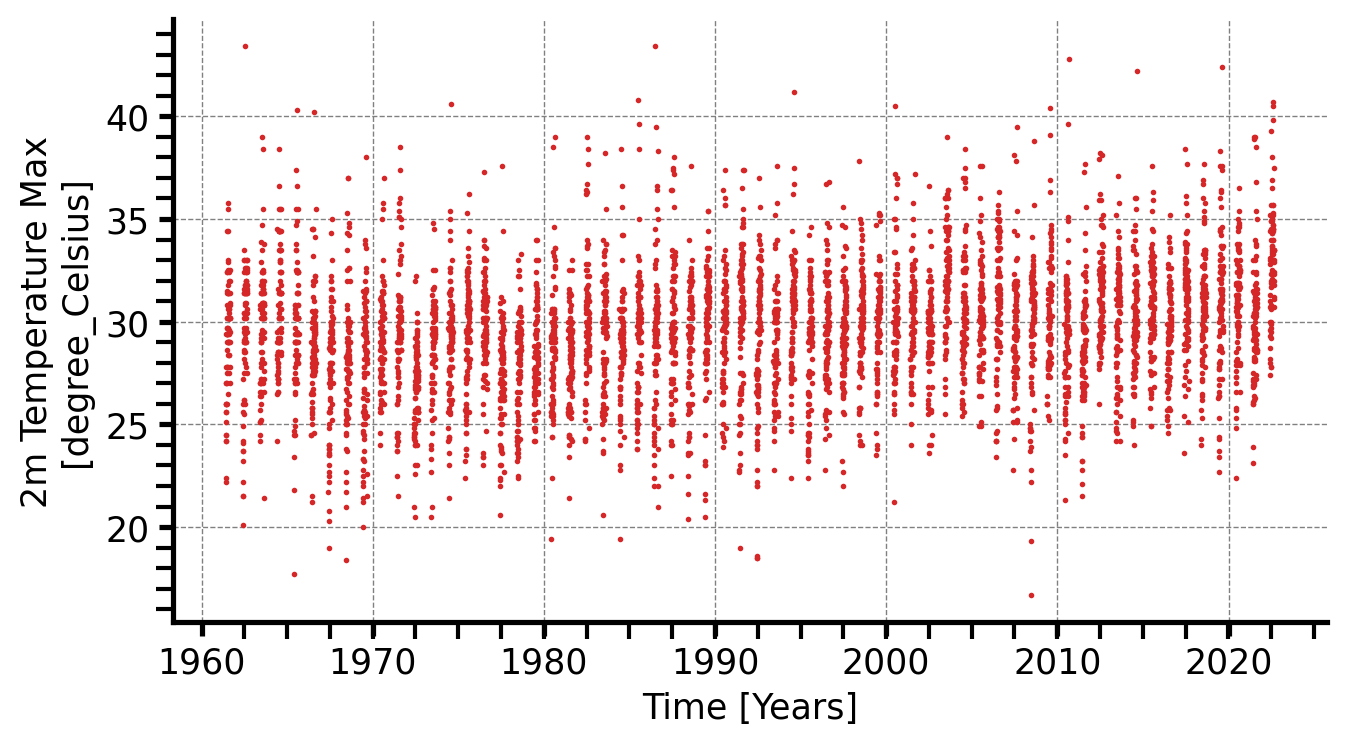

In [21]:
fig, ax, pts = plot_scatter_ts(ds_station[variable].squeeze(), markersize=1.0)
fig.set(
    dpi=100,
    size_inches=(7,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("ts_data.png"))
plt.show()

#### Histogram

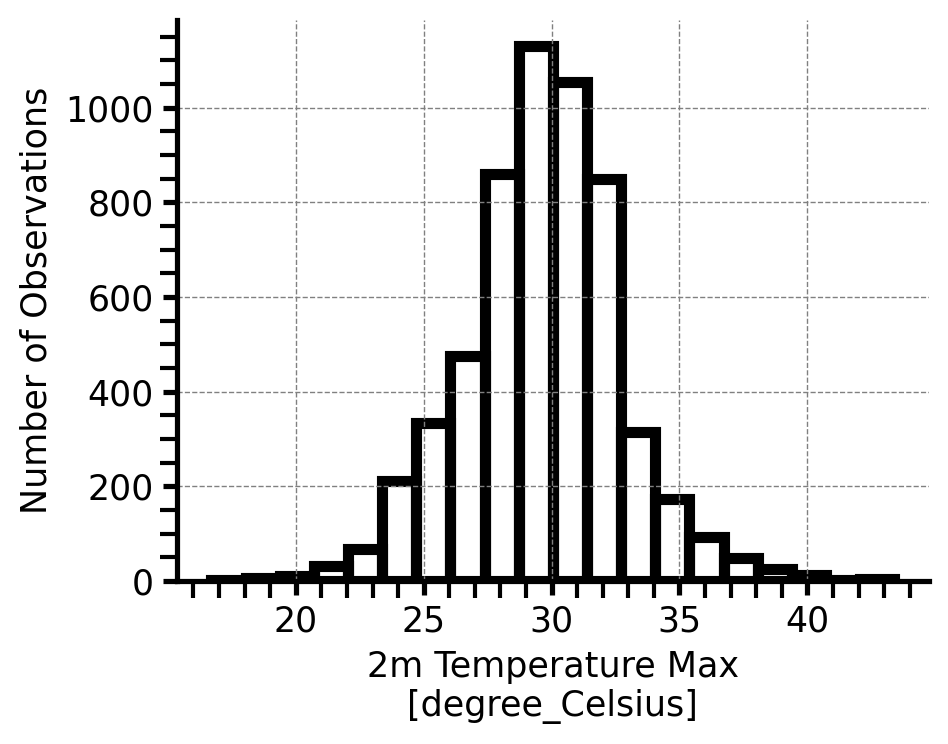

In [22]:
fig, ax = plot_histogram(ds_station[variable])
ax.set(
    title=""
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("hist_data.png"))
plt.show()

#### Density

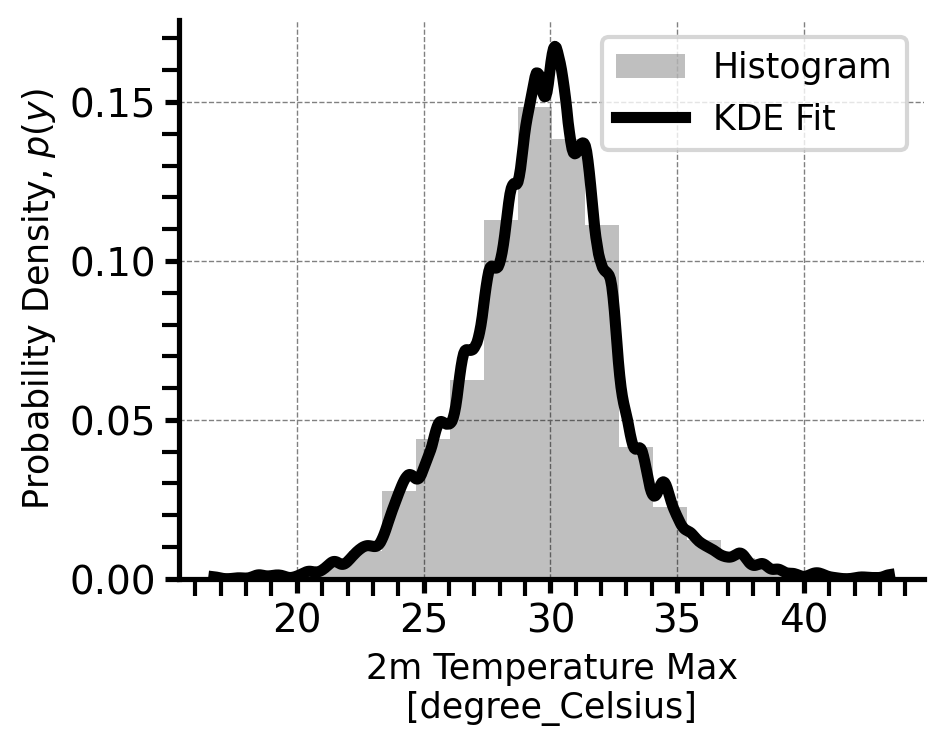

In [23]:
fig, ax = plot_density(ds_station[variable])
ax.set(
    title=""
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("density_data.png"))
plt.show()

### Block Maxima

#### Scatter

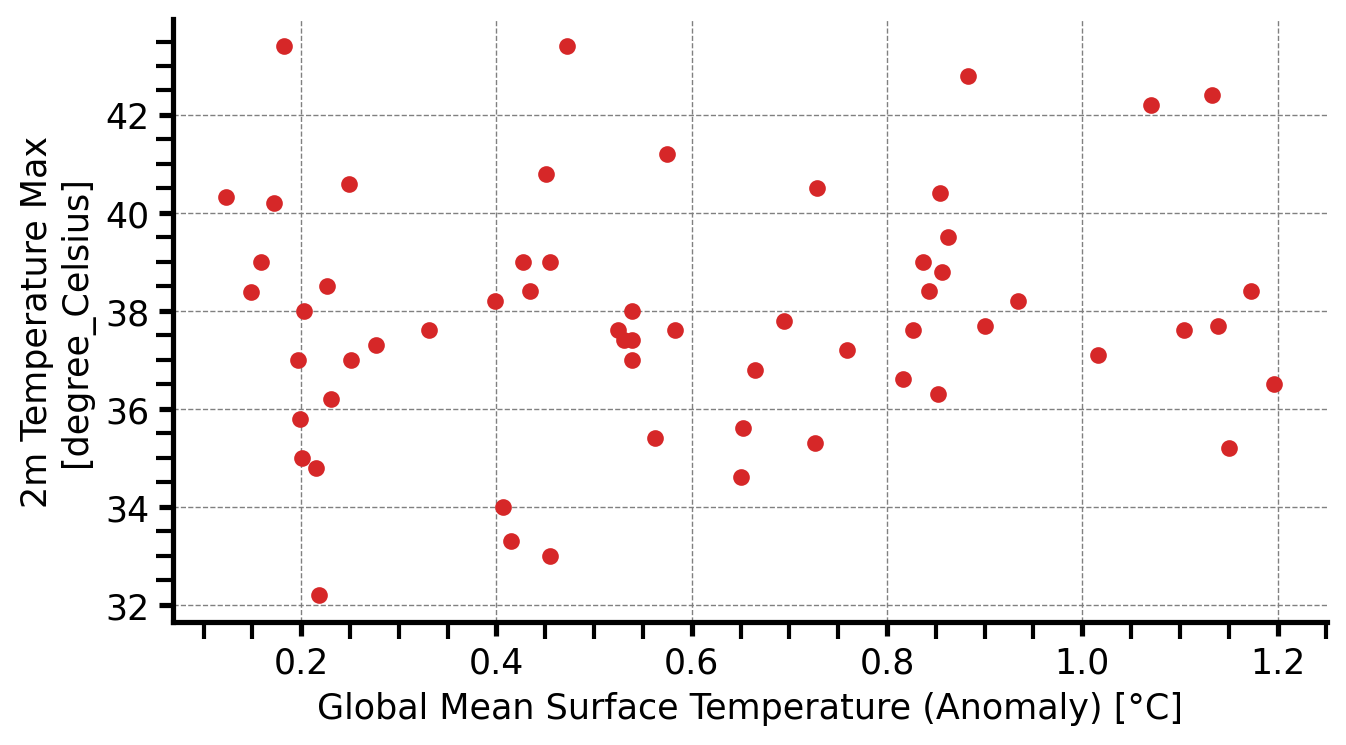

In [24]:
fig, ax, pts = plot_scatter_ts(ds_bm[variable_bm].squeeze(), x_variable="gmst", markersize=5.0)
ax.set(xlabel="Global Mean Surface Temperature (Anomaly) [°C]")
fig.set(
    dpi=100,
    size_inches=(7,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("ts_bm.png"))
plt.show()

#### Histogram

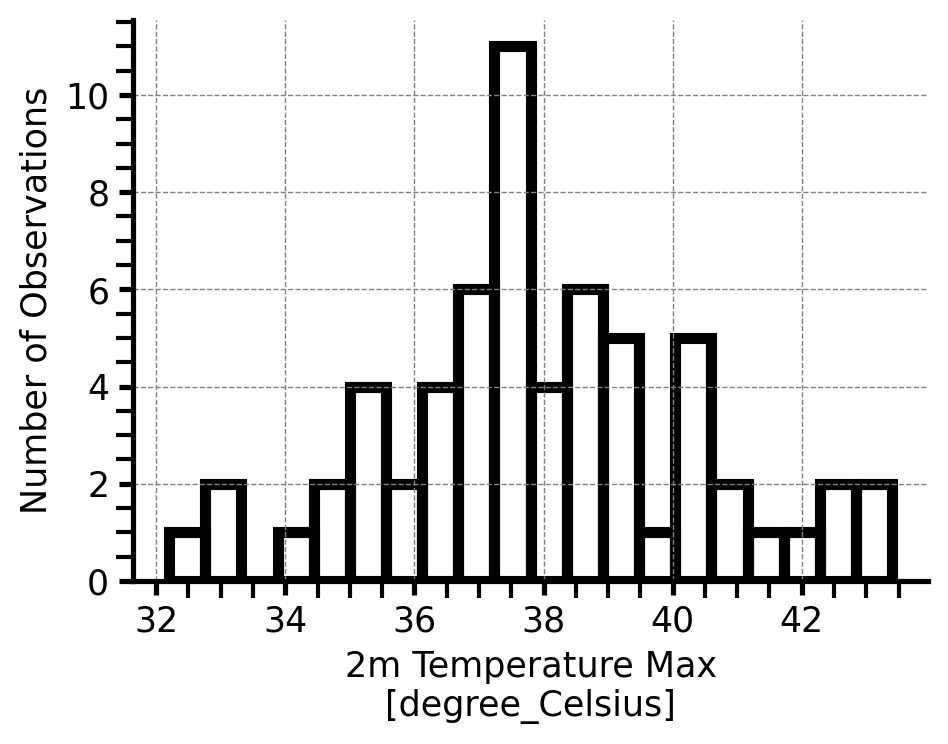

In [25]:
fig, ax = plot_histogram(ds_station[variable_bm])
ax.set(
    title=""
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("hist_bm.png"))
plt.show()

#### Density

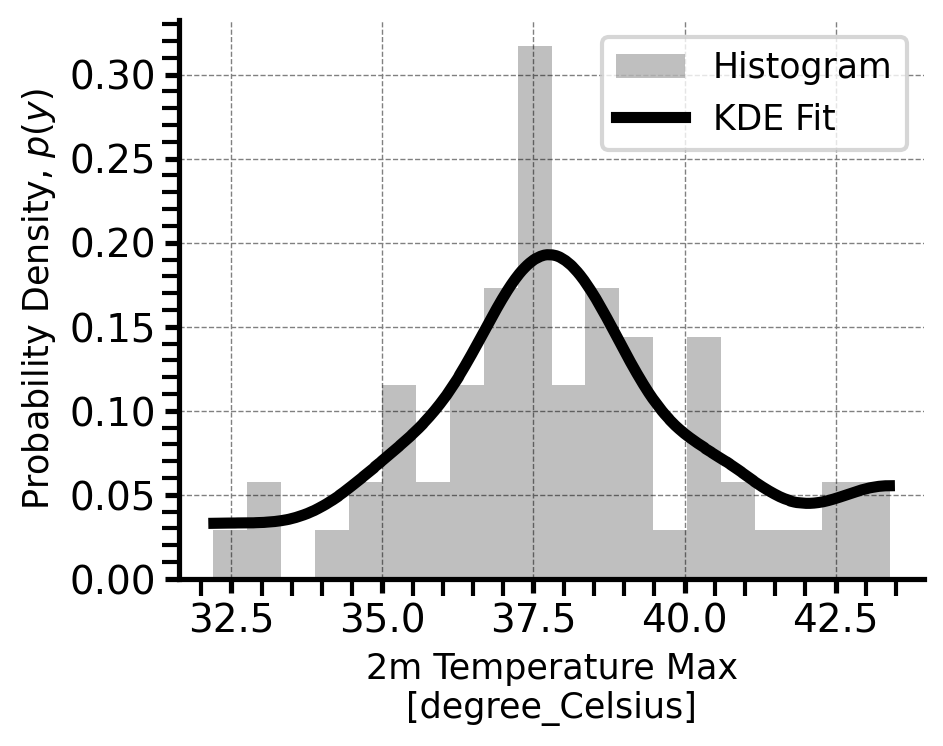

In [26]:
fig, ax = plot_density(ds_station[variable_bm])
ax.set(
    title=""
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("density_bm.png"))
plt.show()

### Save To Folder

In [27]:
clean_data_path = data_path.joinpath("clean_data.nc")
ds_bm.to_netcdf(clean_data_path)

In [28]:
config["clean_data_path"] = str(clean_data_path)

OmegaConf.save(config, config_file_name)

In [29]:
!ls $figures_path

density_bm.png	  hist_bm.png	 ts_bm.png
density_data.png  hist_data.png  ts_data.png


In [30]:
!cat $config_file_name

experiment_name: walkthrough/ts_station_stationary
dataset: aemet
station_id: 8414A
variable: t2m
likelihood: gevd
freq: summer
dependence: temporal
parameterization: linear
config_file_name: aemet_station_nonstationary.yaml
covariate_path: /home/juanjohn/pool_data/dynev4eo/data/clean/gmst.zarr
dataset_path: /home/juanjohn/pool_data/dynev4eo/data/clean/t2m_stations_spain.zarr
exp_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary
figures_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/figures/eda
data_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data
clean_data_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data/clean_data.nc


In [31]:
logger.debug(config_file_name)

2024-12-04 16:27:27.595 | DEBUG    | __main__:<module>:1 - /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/config/config.json
